## Facial Expression Recognition/Classification

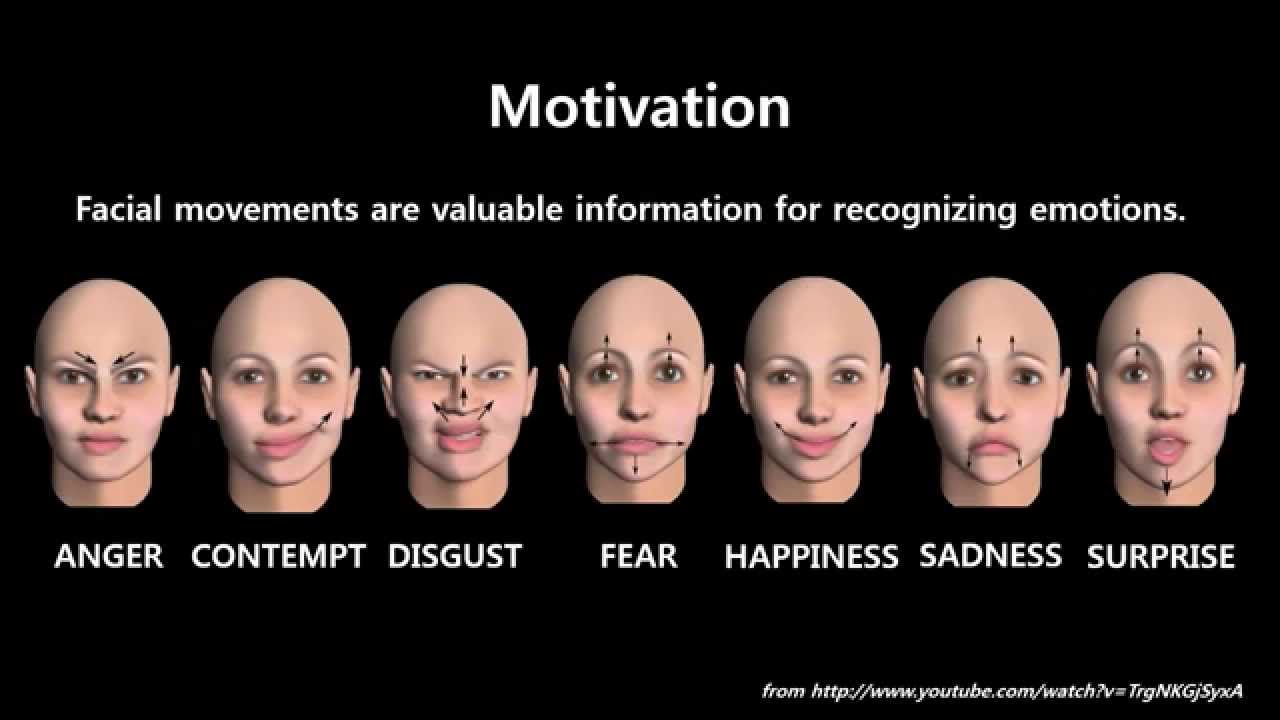

#### Importing required Libraries 

In [10]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten # Flatten converts 2D arrays into a 1D linear vector, Dropout Prevents overfitting by randomly converting few outputs to zero
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
import pydotplus
import pydot
import keras
import graphviz
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

from keras.utils import plot_model
from IPython.display import Image


from sklearn.metrics import accuracy_score
import cv2 as cv

from keras.models import Model
from keras import optimizers
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

#### Loading Data

In [2]:
df=pd.read_csv('/Users/heisenberg/Desktop/Deep_Learning_Code/Facial_Expression_Recognition/fer2013.csv')
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
'''
Angry--1
Disgust --2
Fear--3
Happy--4
Neutral--5
Sad--6
Surprise--7
'''

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
f'The shape of dataset is {df.shape})'

'The shape of dataset is (35887, 3))'

- As it's greyscale images, hence it will only have 1 channel 
- Colored Images represnts 3 channels i.e RGB 
- Here 3 represents 3 columns only
- It looks like pixel column is one big string with 8k+ elements/pixels
- These are pixel intensity values, where each value represents the darkness/greyscale in an image
- However, we know that an image can contains value ranging from 0 to 255 to build an image

In [21]:
print(len(df['pixels'].iloc[0]))
print(len(df['pixels'].iloc[1]))
print(len(df['pixels'].iloc[2]))
print(len(df['pixels'].iloc[3]))

8287
8687
8581
8555


##### Visualizing class labels 
- Looks like data is imbalanced
- Happy has the highest value count
- While Disgust has the lowest

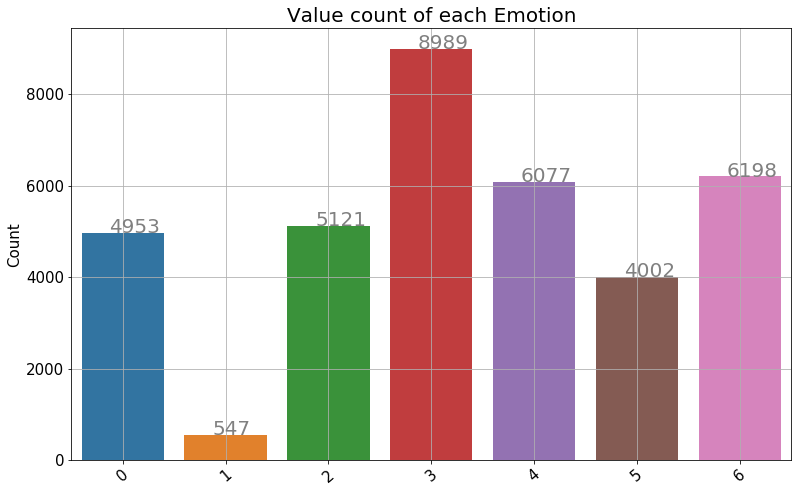

In [4]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Value count of each Emotion", fontsize = 20)
sns.countplot(x = "emotion", data = df)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.27, y = i.get_height()+0.2, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("")
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

###### Creating Training and Testing dataset

In [108]:
x_train=[]
y_train=[]

x_test=[]
y_test=[]

for index,row in df.iterrows():
    pixel=row['pixels'].split(' ')
    try:
        if 'Training' in row['Usage']:
            x_train.append(pixel)
            y_train.append(row['emotion'])
        else:
            x_test.append(pixel)
            y_test.append(row['emotion'])
    except:
        print(f'Some error occured at index:{index} & row:{row}')

x_train=np.array(x_train,'float32')
x_test=np.array(x_test,'float32')

y_train=np.array(y_train,'float32')
y_test=np.array(y_test,'float32')

print(f'Length of our Train dataset/images is {x_train.shape} and {y_train.shape}')
print(f'Length of our Test dataset/images is {x_test.shape} and {y_test.shape}')

Length of our Train dataset/images is (28709, 2304) and (28709,)
Length of our Test dataset/images is (7178, 2304) and (7178,)


###### Data Pre-processing
- Reshaping the data
- OHE of data
- Data Normalization - Standard way to scale values to [0-1], just by dividing the values by 255

In [109]:
x_train = np.reshape(x_train, (x_train.shape[0],48,48,1))   # 48*48*1 = 2304
x_test =  np.reshape(x_test,  (x_test.shape[0],48,48,1))

x_train=x_train/255.0
x_test=x_test/255.0

y_train=np_utils.to_categorical(y_train, df['emotion'].nunique() ).astype(int)
y_test=np_utils.to_categorical(y_test, df['emotion'].nunique() ).astype(int)

print(f'Length of our Train dataset/images is {x_train.shape} and {y_train.shape}')
print(f'Length of our Test dataset/images is {x_test.shape} and {y_test.shape}')

Length of our Train dataset/images is (28709, 48, 48, 1) and (28709, 7)
Length of our Test dataset/images is (7178, 48, 48, 1) and (7178, 7)


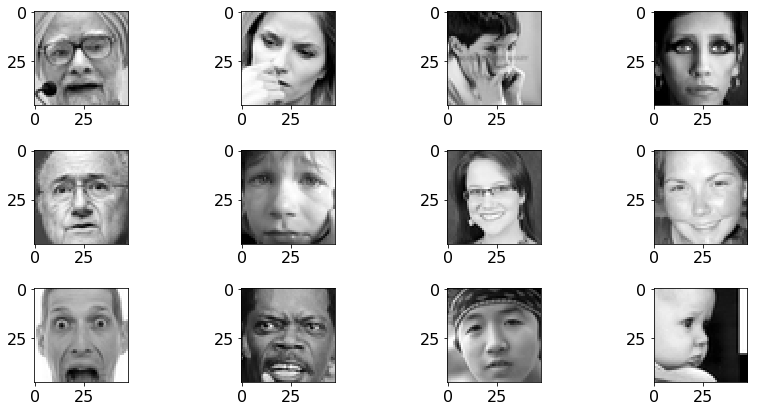

In [273]:
def reading_pixels(start_img,end_img):
    plt.figure(0, figsize=(12,6))
    for i in range(start_img, end_img):
        plt.subplot(3,4,i)
        plt.imshow(x_train[i, :, :, 0], cmap="gray")

    plt.tight_layout()
    plt.show()

reading_pixels(1,13)

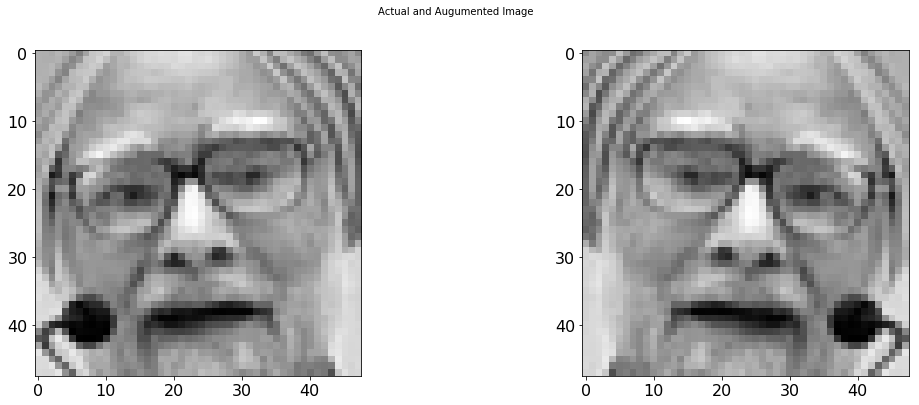

In [276]:
def data_augumentation(image_iloc):
    plt.figure(figsize=(18,6))
    plt.subplot(1, 2, 1)
    plt.suptitle('Actual and Augumented Image', fontsize=10)
    plt.imshow(image_iloc.reshape((48,48)))

    plt.subplot(1, 2, 2)
    plt.imshow(np.flip(x_train, 2)[1].reshape((48,48)))
    plt.show()
    
data_augumentation(x_train[1])

#### Defining CNN Architecture
- CNN with Keras using TensorFlow backend
- Loss function is Cross Entropy as it's multi class classification problem
- Drop out layer will reduce overfitting as it drops random neurons from NN
- L2 Regulaizer penalises the weights during optimisation
- Batch Normalisation ensures a transformation that keeps the mean close to 0 and std. dev to 1. Avoids Internal covariate shifts and speeds up the convergence
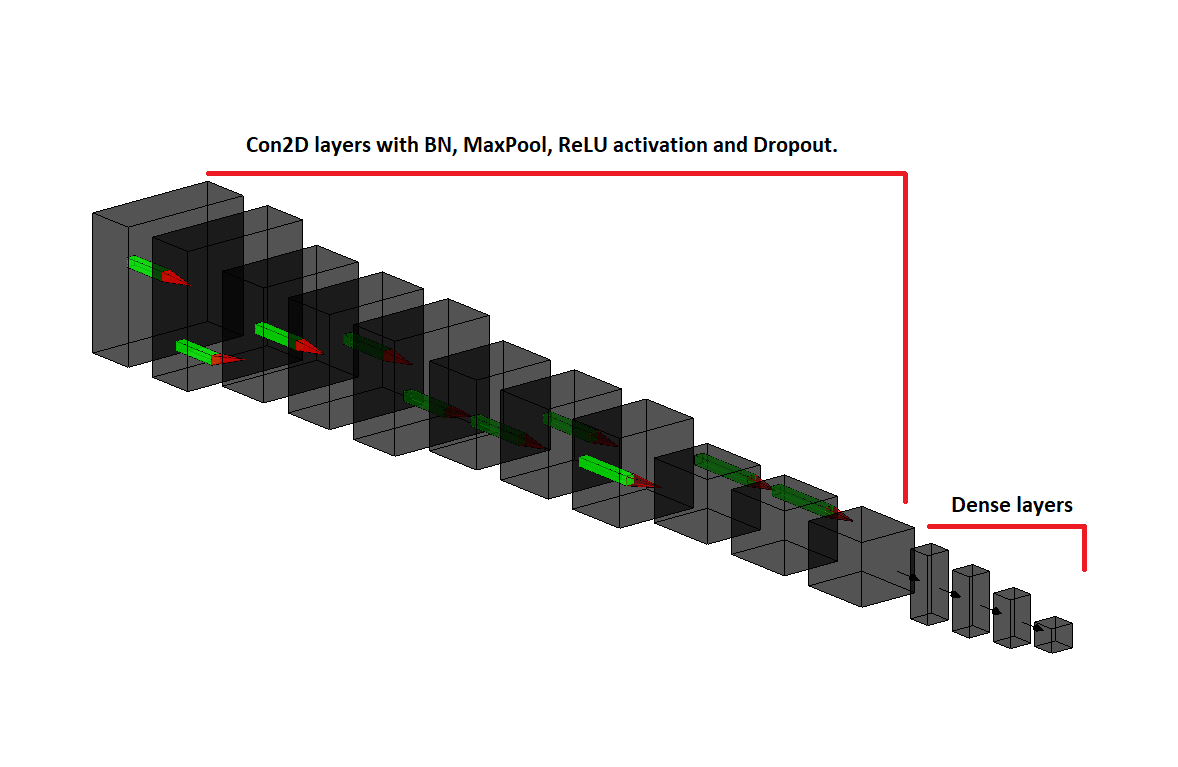

In [93]:
input_shape = (48, 48, 1)
output_classes = 7

model = Sequential()

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_initializer = 'he_normal', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('elu'))
model.add(Dropout(0.3))

model.add(Dense(output_classes))
model.add(Activation('softmax'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 128)       1280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 64)       

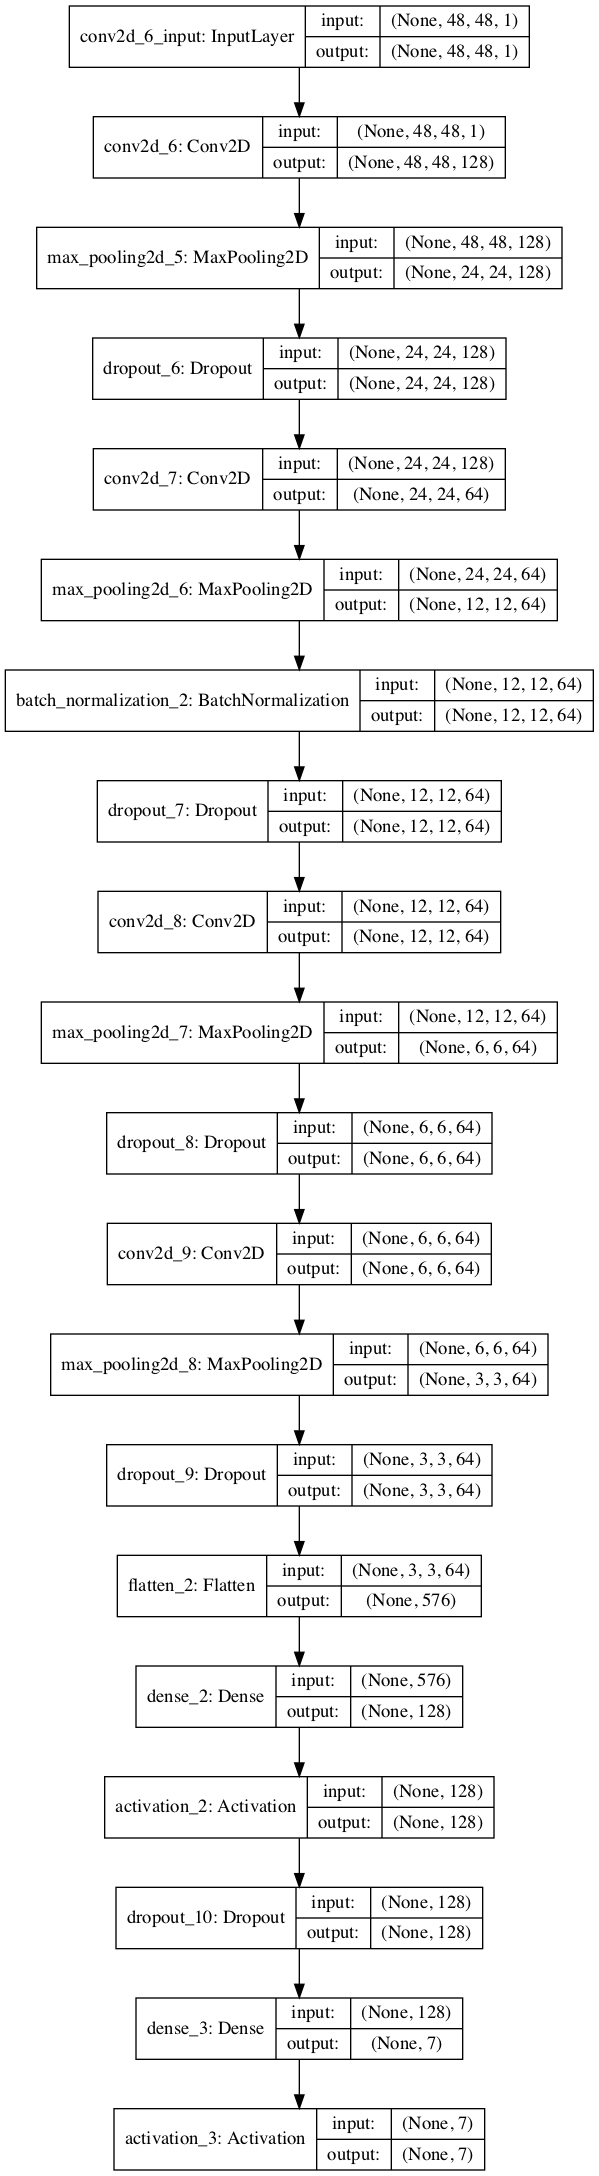

In [103]:
plot_model(model, to_file = 'emotion_arc.png', show_shapes = True, show_layer_names = True)
Image(retina = True, filename = 'emotion_arc.png')

#### Training, Compiling and Saving the model 

- ReduceLROnPlateau - 
- Checkpointer - Saves the model after every epoch which it thinks has the best weights, it's useful in data recovery incase crash happens
- Early_stopper - Stops training when a monitored quantity has stopped improving and optimiser stucked at local minima.
- TensorBoard is a visualization tool provided with TensorFlow.

In [110]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, mode='auto',verbose = 1, restore_best_weights = True)
checkpointer = ModelCheckpoint('/Users/heisenberg/deep_learning_code/Facial_expression_recognition/model_weights/model{epoch:02d}.h5', 
                               monitor='val_loss', 
                               verbose=1, 
                               #period=10,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir = "/Users/heisenberg/deep_learning_code/Facial_expression_recognition/emotion_graph_1",
                             histogram_freq = 0, write_graph = True,
                             write_grads = False, write_images = False, embeddings_freq = 0,
                             embeddings_layer_names = None, embeddings_metadata = None,
                             embeddings_data = None, 
                             update_freq = 'epoch')

batch_size=64
epochs=100

# Training the model
performance= model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[lr_reducer, checkpointer, early_stopper, tensorboard]            
           )

# Sacing the model to the disk
fer_json = model.to_json()
with open('/Users/heisenberg/deep_learning_code/Facial_expression_recognition/model_weights/fer_colab.json', 'w') as json_file:
    json_file.write(fer_json)
model.save_weights('/Users/heisenberg/deep_learning_code/Facial_expression_recognition/model_weights/fer_colab.h5')
print("Saved model to disk")

Instructions for updating:
Use tf.cast instead.
Train on 28709 samples, validate on 7178 samples
Epoch 1/100
28709/28709 [==============================] - 435s 15ms/step - loss: 2.6609 - accuracy: 0.8503 - val_loss: 0.9393 - val_accuracy: 0.8585

Epoch 00001: val_loss improved from inf to 0.93933, saving model to /Users/heisenberg/deep_learning_code/Facial_expression_recognition/model_weights/model01.h5
Epoch 2/100
28709/28709 [==============================] - 413s 14ms/step - loss: 0.6259 - accuracy: 0.8647 - val_loss: 0.4701 - val_accuracy: 0.8665

Epoch 00002: val_loss improved from 0.93933 to 0.47009, saving model to /Users/heisenberg/deep_learning_code/Facial_expression_recognition/model_weights/model02.h5
Epoch 3/100
28709/28709 [==============================] - 423s 15ms/step - loss: 0.4162 - accuracy: 0.8684 - val_loss: 0.3843 - val_accuracy: 0.8719

Epoch 00003: val_loss improved from 0.47009 to 0.38426, saving model to /Users/heisenberg/deep_learning_code/Facial_expression

28709/28709 [==============================] - 406s 14ms/step - loss: 0.3167 - accuracy: 0.8860 - val_loss: 0.3075 - val_accuracy: 0.8889

Epoch 00069: val_loss improved from 0.31018 to 0.30749, saving model to /Users/heisenberg/deep_learning_code/Facial_expression_recognition/model_weights/model69.h5
Epoch 70/100
28709/28709 [==============================] - 409s 14ms/step - loss: 0.3166 - accuracy: 0.8859 - val_loss: 0.3062 - val_accuracy: 0.8897

Epoch 00070: val_loss improved from 0.30749 to 0.30623, saving model to /Users/heisenberg/deep_learning_code/Facial_expression_recognition/model_weights/model70.h5
Epoch 71/100
28709/28709 [==============================] - 411s 14ms/step - loss: 0.3142 - accuracy: 0.8861 - val_loss: 0.3193 - val_accuracy: 0.8842

Epoch 00071: val_loss did not improve from 0.30623
Epoch 72/100
28709/28709 [==============================] - 413s 14ms/step - loss: 0.3151 - accuracy: 0.8863 - val_loss: 0.3113 - val_accuracy: 0.8861

Epoch 00072: val_loss did 

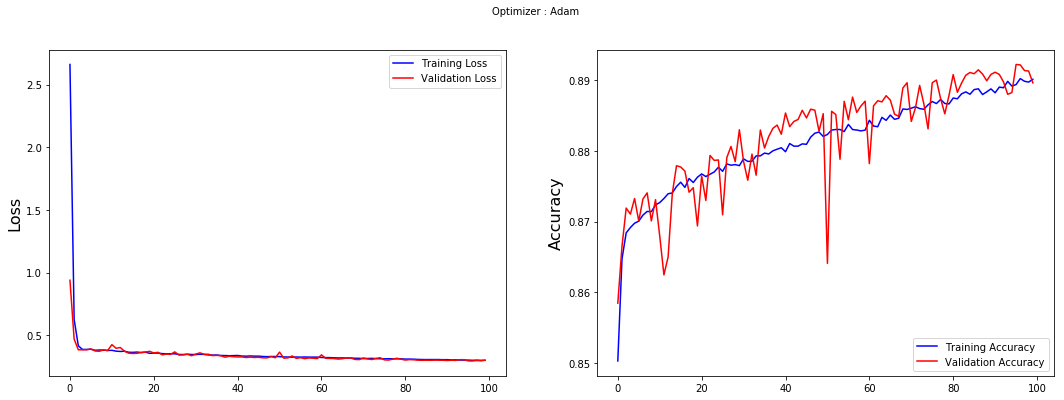

In [111]:
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(performance.history['loss'], color='b', label='Training Loss')
plt.plot(performance.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(performance.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(performance.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

#### Observation :
- The model gives 88.96% of accuracy on Validation dataset and loss is minimized from 0.9 to 0.3
- We will use this model further on webcam live streaming to detect the facial expression/emotion
- To achieve that, we will use OpenCV with HaarCascade Classifier and only focus on the region of face

##### Performance Measurement using various metrices

In [266]:
# prediction and true labels
y_prob = model.predict(x_test, batch_size=32, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y_test]

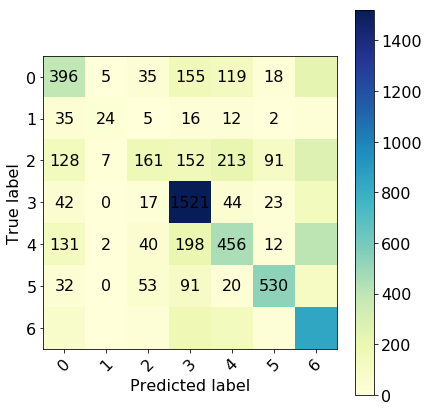

In [267]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    Emotion = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
    labels = np.arange(len(Emotion))
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)

In [268]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=Emotion))

              precision    recall  f1-score   support

       Angry       0.48      0.41      0.44       958
     Disgust       0.62      0.22      0.32       111
        Fear       0.49      0.16      0.24      1024
       Happy       0.66      0.86      0.75      1774
         Sad       0.46      0.37      0.41      1247
    Surprise       0.77      0.64      0.70       831
     Neutral       0.42      0.68      0.52      1233

   micro avg       0.55      0.55      0.55      7178
   macro avg       0.56      0.48      0.48      7178
weighted avg       0.55      0.55      0.52      7178



##### Testing the model 

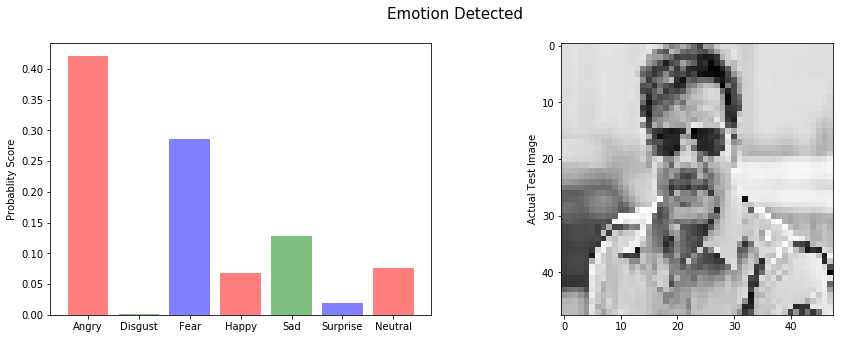

In [254]:
def Emotion_Analysis(pred_img, reshaped_img):
    Emotion = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
    y_label = np.arange(len(Emotion))
 
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.suptitle('Emotion Detected',fontsize=15)
    plt.bar(y_label, pred_img, align='center', alpha=0.5, color=['r','g','b'])
    plt.xticks(y_label, Emotion, fontsize=10)
    plt.ylabel('Probablity Score', fontsize=10)

    plt.subplot(1, 2, 2)
    x = np.array(reshaped_img, 'float32')
    x = x.reshape([48, 48]);
    plt.ylabel('Actual Test Image', fontsize=10)
    plt.gray()
    plt.imshow(x)
    plt.show()

def image_processing(test_image):
    test_image = image.load_img(test_image, grayscale=True, target_size=(48, 48))
    test_x = image.img_to_array(test_image)
    test_x = np.expand_dims(test_x, axis = 0)
    test_x /= 255
    test_x_pred = model.predict(test_x)
    Emotion_Analysis(test_x_pred[0],test_x)
    
image_path='test_images/singham.jpeg'

image_processing(image_path)

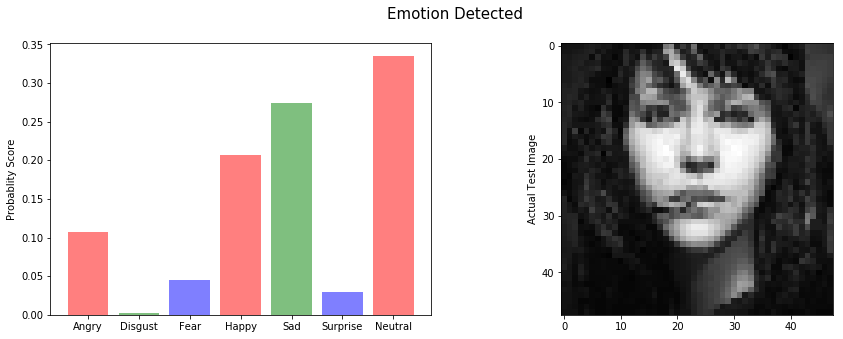

In [255]:
image_path='test_images/sad_girl.jpeg'
image_processing(image_path)

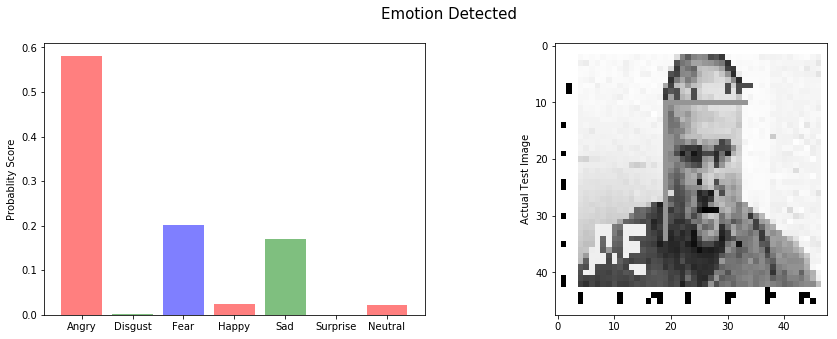

In [256]:
image_path='test_images/angry.png'
image_processing(image_path)

#### Loading the model back from the disk

In [4]:
from keras.models import load_model
from keras.models import model_from_json

In [5]:
with open('model_weights/fer_colab.json','r') as f:
    json = f.read()
model = model_from_json(json)

model.load_weights('model_weights/fer_colab.h5')
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Loaded model from disk


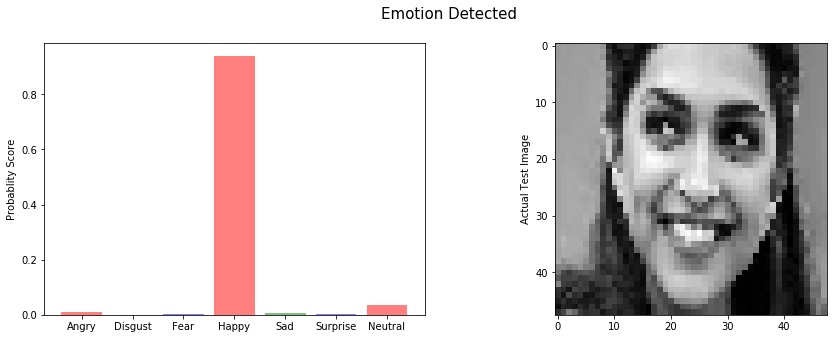

In [12]:
image_path='test_images/happy.jpeg'
image_processing(image_path)

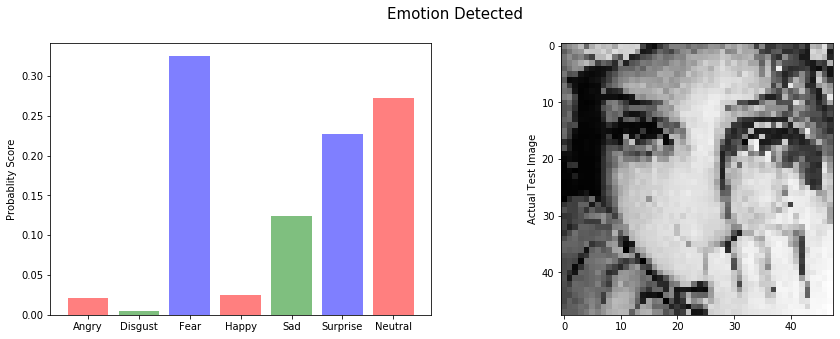

In [24]:
image_path='test_images/sad3.jpg'
image_processing(image_path)